In [1]:

# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

raw_data = util.load_dataset('7_gecco2019_train_water_quality.csv')

2025-03-10 08:35:06.808165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 08:35:06.887002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 08:35:06.949549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741592107.009262    9888 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741592107.025823    9888 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741592107.154064    9888 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Dataset
These datasets at hand were published as part of the GECCO 2019 Industrial Challenge. The aim of the challenge was to develop a contamination detector that can reliably predict drinking water contamination based on various water parameters. For this purpose, the following parameters were collected every minute at relevant points in a drinking water treatment plant in Thuringia over a period of almost 5 months:
1. `Time`: The time at which the measured values were collected
2. `Tp`: The water temperature in ºC
3. `pH`: The pH value of the water
4. `Cond`: The electrical conductivity of the water, given in S/m
5. `Turb`: The turbidity of the water, given in FNU
6. `SAC`: The water's spectral absorption coefficient, given in 1/m
7. `PFM`: Pulse Frequency Modulation, given in Hz
8. `Event`: This value indicates whether contamination was present or not

In [2]:
print(raw_data.describe())

                  Tp             pH           Cond           Turb  \
count  132266.000000  132272.000000  132276.000000  132275.000000   
mean        8.041982       8.533168       0.021095       0.128368   
std         0.893687       0.052646       0.000347       0.005928   
min         0.000000       0.000000       0.000000       0.000000   
25%         7.250000       8.502780       0.020871       0.127160   
50%         7.880000       8.539630       0.021102       0.127754   
75%         8.710000       8.563490       0.021327       0.128686   
max        10.300000       8.666760       0.023214       1.782850   

                 SAC            PFM  
count  132280.000000  132269.000000  
mean        4.100425      68.660980  
std         0.304104      11.420472  
min         0.000000      42.163100  
25%         3.816430      60.484900  
50%         4.125515      71.440700  
75%         4.395750      79.076900  
max         6.102071      84.815100  


## Investigation
Let's have a look at the feature values over the entire timespan.

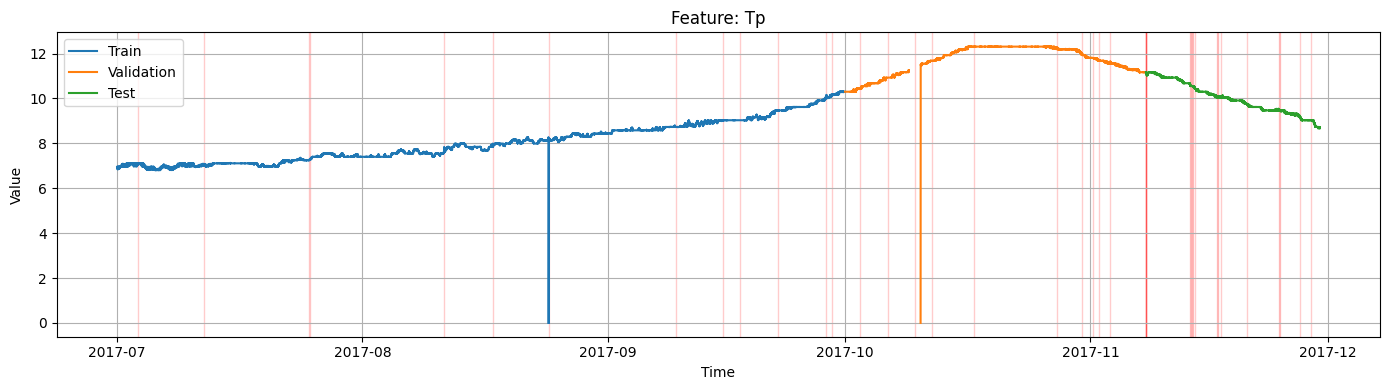

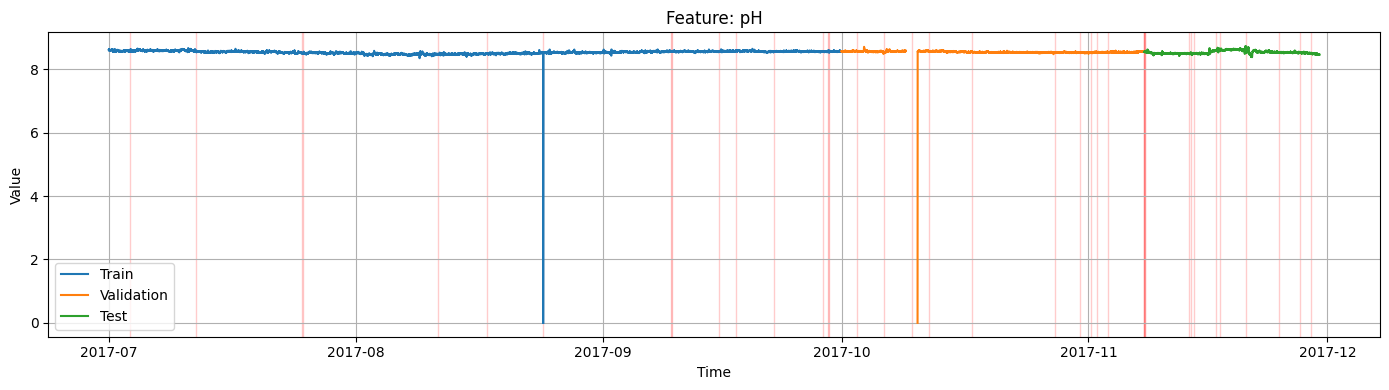

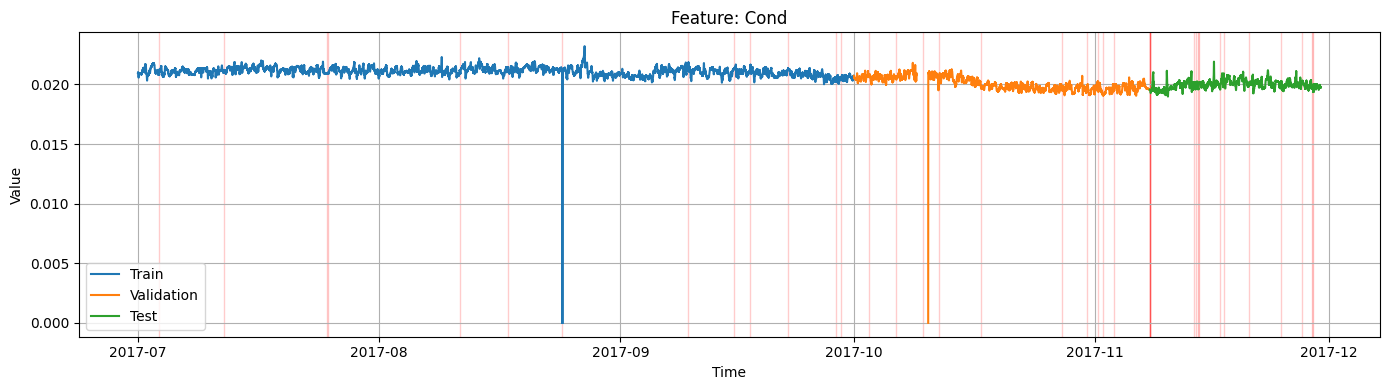

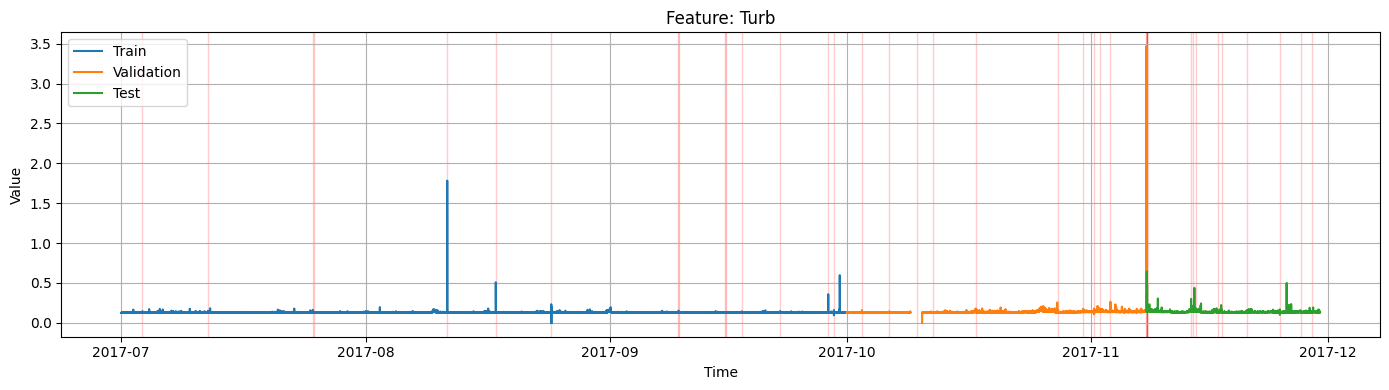

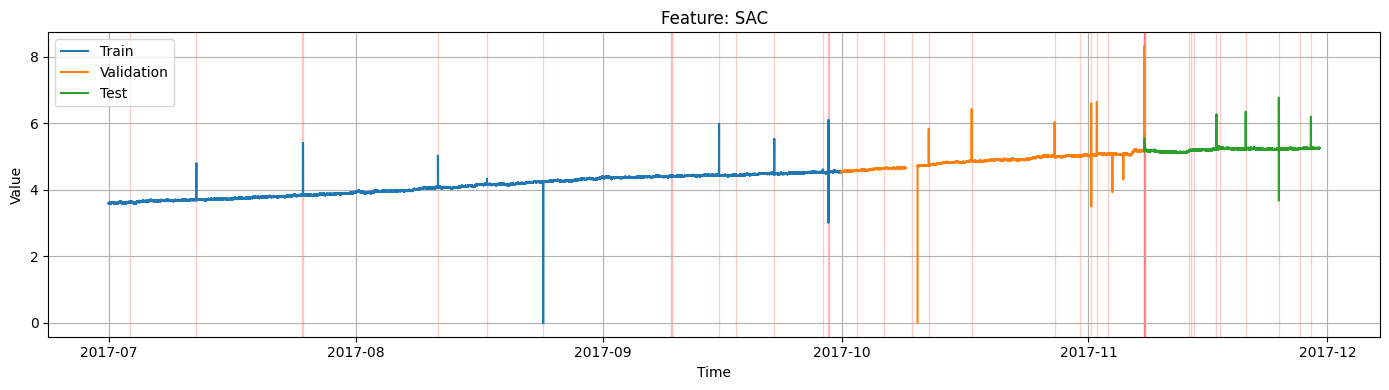

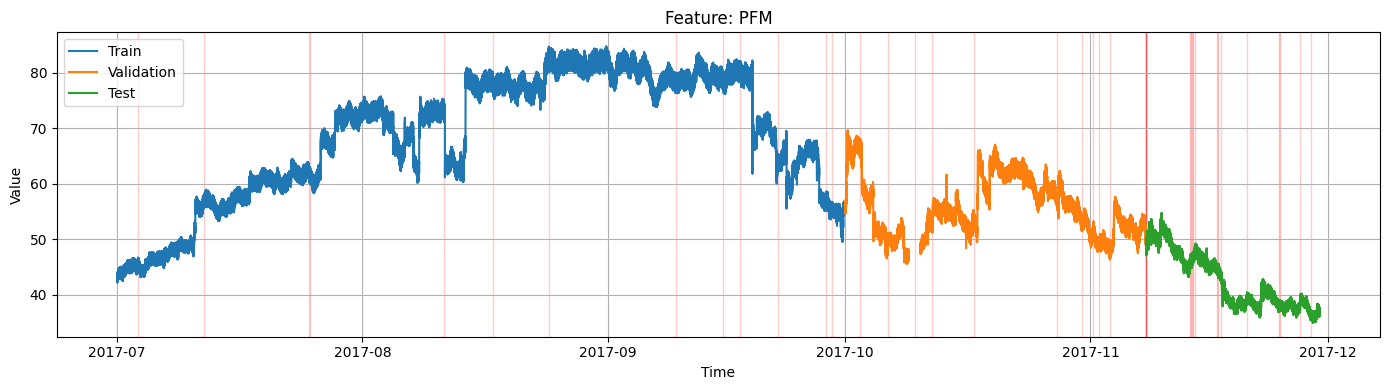

In [3]:
# Load the datasets
data_train = util.load_dataset('7_gecco2019_train_water_quality.csv')
data_val = util.load_dataset('8_gecco2019_valid_water_quality.csv')
data_test = util.load_dataset('6_gecco2019_test_water_quality.csv')

# Get the feature columns
feature_columns = util.get_feature_columns(data_train)

# Create a dictionary for easy iteration over the datasets
datasets = {
    'Train': data_train,
    'Validation': data_val,
    'Test': data_test
}

# Plot each feature over the full timespan and add red spans for contamination events
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Plot each dataset's feature
    for label, df in datasets.items():
        # Plot the feature values using the DataFrame index as x-axis.
        plt.plot(df[feature], label=label)

        # Highlight contamination periods
        util.highlight_contamination(df)

    plt.title(f'Feature: {feature}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Contamination Events
It is also important to understand how frequently contamination events occur in the dataset. We can do this by counting the number of True values in the `Event` column.
We can observe, that from a total of 218,880 samples, only 628 are contamination events. While a low number of contamination events is fortunate for the operators of the water treatment plant, it is not ideal for machine learning models.

In [4]:
# Make a dictionary for easy iteration over the datasets
datasets = {
    "Train": data_train,
    "Validation": data_val,
    "Test": data_test
}

for name, df in datasets.items():
    total = len(df)
    # Count occurrences of each value in the 'Event' column
    counts = df['Event'].value_counts()
    # Calculate the number of contamination events (True values)
    contamination_count = df['Event'].sum()
    # Calculate the contamination percentage
    contamination_percentage = (contamination_count / total) * 100

    print(f"Dataset: {name}")
    print("Event Counts:")
    print(counts)
    print(f"Contamination events (True): {contamination_count} ({contamination_percentage:.2f}%)")
    print("-" * 40)

Dataset: Train
Event Counts:
Event
False    132268
True        212
Name: count, dtype: int64
Contamination events (True): 212 (0.16%)
----------------------------------------
Dataset: Validation
Event Counts:
Event
False    54525
True       225
Name: count, dtype: int64
Contamination events (True): 225 (0.41%)
----------------------------------------
Dataset: Test
Event Counts:
Event
False    31459
True       191
Name: count, dtype: int64
Contamination events (True): 191 (0.60%)
----------------------------------------


# Missing Values
First, we see that most of our values are floating point numbers, except for the `Event` column which is our label, that is,
whether we are dealing with an anomaly or not.

In [5]:
print("Columns: ")
print({column: raw_data[column].dtype for column in raw_data.columns})
raw_data.describe()

Columns: 
{'Tp': dtype('float64'), 'pH': dtype('float64'), 'Cond': dtype('float64'), 'Turb': dtype('float64'), 'SAC': dtype('float64'), 'PFM': dtype('float64'), 'Event': dtype('bool')}


,Tp,pH,Cond,Turb,SAC,PFM
count,132266.000000,132272.000000,132276.000000,132275.000000,132280.000000,132269.000000
mean,8.041982,8.533168,0.021095,0.128368,4.100425,68.660980
std,0.893687,0.052646,0.000347,0.005928,0.304104,11.420472
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.163100
25%,7.250000,8.502780,0.020871,0.127160,3.816430,60.484900
50%,7.880000,8.539630,0.021102,0.127754,4.125515,71.440700
75%,8.710000,8.563490,0.021327,0.128686,4.395750,79.076900
max,10.300000,8.666760,0.023214,1.782850,6.102071,84.815100


We will now look at the alignment and completeness of the sample timeslots:

In [6]:
sample_delta = (raw_data.index[1] - raw_data.index[0])
(raw_data.index[1:] - raw_data.index[:-1]).value_counts()

Time
0 days 00:01:00    132479
Name: count, dtype: int64

We see that the timeslots are regular and not missing.

Now, we will look at missing values:

In [7]:
print("Columns containing missing values:")
print(raw_data.isna().any())
print("Some rows containing missing values:")
raw_data.loc[raw_data.isna().any(axis=1)].head()

Columns containing missing values:
Tp        True
pH        True
Cond      True
Turb      True
SAC       True
PFM       True
Event    False
dtype: bool
Some rows containing missing values:


,Tp,pH,Cond,Turb,SAC,PFM,Event
Time,,,,,,,
2017-07-01 13:24:00,NaN,NaN,NaN,NaN,NaN,NaN,False
2017-07-01 17:00:00,NaN,8.58873,NaN,0.126537,3.58901,NaN,False
2017-07-02 22:08:00,NaN,NaN,NaN,NaN,NaN,NaN,False
2017-07-03 01:46:00,7.1,8.55185,0.021717,NaN,NaN,44.7191,False
2017-07-03 05:23:00,NaN,NaN,NaN,NaN,NaN,NaN,False


As we can see, there are quite a few missing values in our dataset. Each column has some.

We will now try to characterize the distribution in which they show up.

In [8]:
for column in raw_data.drop(columns=["Event"]).columns:
    print()
    print("Column:", util.bold(column))
    series = util.calculate_na_series(raw_data[column])
    for length, count in Counter(map(int, series[:, 1])).most_common():
        print(f"There are {util.bold(count)} NA-sequences of length {util.bold(length)}")


Column: Tp
There are 201 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: pH
There are 195 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: Cond
There are 191 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: Turb
There are 195 NA-sequences of length 1
There are 1 NA-sequences of length 10

Column: SAC
There are 188 NA-sequences of length 1
There are 1 NA-sequences of length 2
There are 1 NA-sequences of length 10

Column: PFM
There are 198 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10


We see that most missing values just come up randomly and not in a bunch.
The segments of 10 consecutive NA values across all columns seems suspicious though.

Let's see if this is the same for all.

In [9]:
collective_na_series = util.calculate_true_series(raw_data.drop(columns="Event").isna().to_numpy().all(axis=1))
collective_na_series[collective_na_series[:,1] > 1]

array([[78550,    10]])

Indeed, we see that there is only one index with a series of timestamps where all entries are 0 (that is more than timeslot long).
It starts at index 78550.

Since most of them however, just come up individually, we would expect that naive filling algorithms should perform well enough as more complex ones.

By the way, respectively the other series' with more than one consecutive Na look like this. Note that all of them are classified as an anomaly.

In [10]:
for column in raw_data.drop(columns="Event").columns:
    longer_segments = series[np.logical_and(series[:, 1] > 1, series[:, 1] < 10)]
    display([raw_data.iloc[i:i + l] for i, l in longer_segments])

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

## Anomalies
In order to train our models, we need a dataset which does not contain anomalies.
Therefore, we will now do the same analysis we did for missing values with anomalies in our training set.
We do this so we can characterize the distribution with which anomalies are distributed across time.

Afterwards, we will overwrite all anomalies with NaN and treat them as missing values.
We then look for a segment with few missing values. 
Using the uniform distribution of the original missing values, delete some of the values in that segment.
After, we repeat but using the distribution of the anomalies.
Then, we can use different strategies and compare how well they reconstruct the original distribution.

In [11]:
anomaly_mask = raw_data["Event"]
logging.basicConfig(level=logging.DEBUG)
series = util.calculate_true_series(anomaly_mask)
c = Counter(map(int, series[:, 1]))
for length, count in sorted(c.items()):
    print(f"There are {util.bold(count)} NA-sequences of length {util.bold(length)}")

There are 1 NA-sequences of length 4
There are 1 NA-sequences of length 6
There are 1 NA-sequences of length 7
There are 1 NA-sequences of length 12
There are 1 NA-sequences of length 14
There are 3 NA-sequences of length 16
There are 1 NA-sequences of length 17
There are 1 NA-sequences of length 23
There are 1 NA-sequences of length 24
There are 1 NA-sequences of length 26
There are 1 NA-sequences of length 31


We see that the distribution is rather wide.
We will approximate it using a normal distribution:

In [12]:
anomaly_distribution_std = series[:, 1].std()
anomaly_distribution_mean = series[:, 1].mean()
anomaly_distribution_overall_percentage = series[:, 1].sum() / len(anomaly_mask)
print(f"Mean: {anomaly_distribution_mean}, std: {anomaly_distribution_std}, overall percentage of anomalies: {anomaly_distribution_overall_percentage}")

Mean: 16.307692307692307, std: 7.759704746411381, overall percentage of anomalies: 0.0016002415458937198


As we mentioned for taining, we need to get rid of all anomalies in the training data.
To do this, we will set them to NaNs.
We also standardize the data so all evaluation metrics are comparable.

In [13]:
no_anomaly_data_not_std = util.remove_anomalies(raw_data)
no_anomaly_data = (no_anomaly_data_not_std - no_anomaly_data_not_std.mean()) / no_anomaly_data_not_std.std()

## Filling Missing Values
We want to try and evaluate all methods separately. We will evaluate it using the RMSE analogously to the lecture.

I.e., we will look for mostly intact segments, remove values arbitrarily, and then fill them using the methods.

## Simple Filling
Because filling values for one column is independent of the others, we can fill the missing values for each column separately in order to maximize the size of the validation set.
Prior, we calculate the proportion of Na values in the entire column and delete the same
proportion from our validation set.
Assuming the missing values are uniformly randomly distributed, our calculated error will tend towards the true error of our method.

In [14]:
permitted_missing_values = 30
bounds = {column: util.find_best_segment_in_series(no_anomaly_data[column], permitted_missing_values) for column in no_anomaly_data}
all_columns_bounds = util.find_best_segment_in_series(no_anomaly_data, permitted_missing_values * len(no_anomaly_data.columns))
print("Bounds when counting across all columns:", all_columns_bounds)
print("Bounds per column: ")
bounds

Bounds when counting across all columns: (35136, 57480)
Bounds per column: 


{'Tp': (35136, 57916),
 'pH': (36557, 59225),
 'Cond': (36557, 59225),
 'Turb': (36557, 58353),
 'SAC': (35136, 57480),
 'PFM': (36338, 59225)}

In the following cell, we try all of the column–wise algorithms and measure their performance.

In [15]:
# Initialize a list to collect statistics for each column
stats_list = []
filled_data = pd.DataFrame(index=raw_data.index)
for column in no_anomaly_data.columns:
    # We multiply by 40 because otherwise, we would have very few
    na_proportion = raw_data[column].isna().sum() / len(raw_data[column]) * 40
    logging.debug(f"Column: {column}, NA proportion: {na_proportion}")

    # Find the best segment
    segment_bounds = bounds[column]
    segment = no_anomaly_data[column].iloc[segment_bounds[0]:segment_bounds[1]]
    segment_mv = util.simulate_missing_values(segment, na_proportion, anomaly_distribution_mean, anomaly_distribution_std, anomaly_distribution_overall_percentage)
    
    drop_count = round(len(segment) * na_proportion)
    original_nans = segment.isnull()
    added_nans = segment_mv.isnull() & ~original_nans

    # Define interpolation methods
    args = [
        {'method': 'linear'},
        {'method': 'polynomial', 'order': 2},
        {'method': 'spline', 'order': 4},
        {'method': 'nearest'}
    ]

    min_rmse = float('inf')
    min_fill_function = None
    min_name = None

    # Function to calculate RMSE and update stats
    rmse_methods = {}
    def calc_rmse(name, fill_function):
        global min_rmse, min_fill_function, min_name
        filled = fill_function(segment_mv)
        rmse = np.sqrt(mean_squared_error(segment[added_nans], filled[added_nans]))
        # Store RMSE for this method in the stats dictionary
        rmse_methods[f'RMSE {name}'] = rmse
        if rmse < min_rmse:
            min_rmse, min_fill_function, min_name = rmse, fill_function, name

    # Calculate RMSE for each method
    for a in args:
        method_name = a.get('method')
        # Capture 'a' in the lambda to avoid late binding
        calc_rmse(method_name, lambda arr, a=a: arr.interpolate(**a))
    calc_rmse("ffill", lambda arr: arr.ffill())
    calc_rmse("bfill", lambda arr: arr.bfill())

    filled_data[column] = min_fill_function(raw_data[column])

    # Initialize stats dictionary for this column
    stats = {
        'Column': column,
        'Best method': min_name,
        'Best RMSE': min_rmse,
        **rmse_methods,
        '# samples in Validation': len(segment),
        '% of NaN in entire column': na_proportion,
        '# Deleted for test set': added_nans.sum(),
        '# NA in validation set': segment.isna().sum()
    }

    stats_list.append(stats)

# Create DataFrame from collected stats
stats_df = pd.DataFrame(stats_list)

# Optional: Set 'Column' as the index
stats_df.set_index('Column', inplace=True)

# Display the DataFrame
stats_df.T

Column,Tp,pH,Cond,Turb,SAC,PFM
Best method,linear,linear,linear,linear,linear,linear
Best RMSE,0.005388,0.041795,0.017733,0.42103,0.023809,0.085168
RMSE linear,0.005388,0.041795,0.017733,0.42103,0.023809,0.085168
RMSE polynomial,0.010644,0.098143,0.040883,0.973867,0.087342,0.233855
RMSE spline,0.060279,0.4562,0.813688,0.82796,0.045805,0.192818
RMSE nearest,0.006313,0.060303,0.031452,0.565704,0.027304,0.097722
RMSE ffill,0.00792,0.082635,0.055864,0.562649,0.027039,0.096565
RMSE bfill,0.007149,0.084663,0.049938,0.425256,0.026758,0.097108
# samples in Validation,22780,22668,22668,21796,22344,22887
% of NaN in entire column,0.064614,0.062802,0.061594,0.061896,0.060386,0.063708


As you can see, for each column we calculate the percentage of missing values.
Assuming an uniform distribution, we then calculate how many values to delete at random.

Afterwards, we do the same for the anomaly distribution, where we already know the parameters of the normal distribution.

Then, we can calculate the accuracy of the filling methods.

This table shows the performance of each method as well as stats like the proportion of Na values in the column and the number of deleted samples for producing the test set with missing values.

Now, we want to try Gaussian Processes as well.
In contrast to the methods, we apply this for all columns at once.

In [16]:
gp_segment = no_anomaly_data.iloc[all_columns_bounds[0]:all_columns_bounds[1]][:5000] # We take a subset of the data to speed up the calculations
gp_segment_mv = util.simulate_missing_values(gp_segment, anomaly_distribution_overall_percentage, anomaly_distribution_mean, anomaly_distribution_std, anomaly_distribution_overall_percentage)
gp_original_nans = gp_segment.isnull().to_numpy()
gp_added_nans = gp_segment_mv.isnull().to_numpy() & ~gp_original_nans

gp_segment_mv.reset_index(drop=True, inplace=True)
gp_segment_mv.drop("Time", axis=1, inplace=True, errors='ignore')
gp_segment.reset_index(drop=True, inplace=True)
gp_segment.drop("Time", axis=1, inplace=True, errors='ignore')

Having prepared the data with new missing values, we now perform the filling.
For that, we train the process on all rows with no missing values.
Afterwards, we predict entire rows containing at least one missing values and
in the end, we calculate the RMSE between each cell which was filled and its original, correct value.

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel

gp_reconstructed_segment = gp_segment_mv.copy()
gp_all_nan_mask = gp_segment_mv.isnull()
indices_with_missing_values = gp_all_nan_mask.any(axis=1).to_numpy()

kernel_rbf = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
kernel_matern = Matern(length_scale=1, length_scale_bounds=(1e-2, 1e2), nu=1.5)
kernel_rq = RationalQuadratic(length_scale=1, alpha=1, length_scale_bounds=(1e-2, 1e2))
kernel_rbf_white = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel_rbf_white, n_restarts_optimizer=0)
gpr.fit(gp_segment_mv.index.to_numpy()[~indices_with_missing_values].reshape(-1, 1), gp_segment_mv[~indices_with_missing_values])
gp_filled_gaps = gpr.predict(gp_segment_mv.index.to_numpy()[indices_with_missing_values].reshape(-1, 1))

gp_reconstructed_segment = gp_segment_mv.copy()
gp_reconstructed_segment[indices_with_missing_values] = gp_filled_gaps

true_values = gp_segment.iloc[gp_added_nans]
predicted_values = gp_reconstructed_segment.iloc[gp_added_nans]
mse = ((true_values - predicted_values) ** 2).mean()
rmse_columns = np.sqrt(mse)

stats_with_gp = stats_df.T.copy()
stats_with_gp.loc['GP'] = rmse_columns

stats_with_gp

Column,Tp,pH,Cond,Turb,SAC,PFM
Best method,linear,linear,linear,linear,linear,linear
Best RMSE,0.005388,0.041795,0.017733,0.42103,0.023809,0.085168
RMSE linear,0.005388,0.041795,0.017733,0.42103,0.023809,0.085168
RMSE polynomial,0.010644,0.098143,0.040883,0.973867,0.087342,0.233855
RMSE spline,0.060279,0.4562,0.813688,0.82796,0.045805,0.192818
RMSE nearest,0.006313,0.060303,0.031452,0.565704,0.027304,0.097722
RMSE ffill,0.00792,0.082635,0.055864,0.562649,0.027039,0.096565
RMSE bfill,0.007149,0.084663,0.049938,0.425256,0.026758,0.097108
# samples in Validation,22780,22668,22668,21796,22344,22887
% of NaN in entire column,0.064614,0.062802,0.061594,0.061896,0.060386,0.063708


As we can see, the Gaussian Process performs better on some columns and worse on others.
However, because it is so difficult and inperformant to train, we will just use the linear filling going forward.

## Standardize the Data
Another important step is to standardize the data as many models are based on the assumption of normal distributions. This is done by subtracting the mean and dividing by the standard deviation of each column.

In [18]:
std_data = raw_data.copy()
data_columns = list(std_data.columns[0:-1])
std_data[data_columns] = (std_data[data_columns] - std_data[data_columns].mean()) / std_data[data_columns].std()
std_data["Event"] = std_data["Event"].astype(int)

## Heatmap over the Whole Timespan
We can now visualize the data using a heatmap to get a different perspective on the development of the different features over time. This lets us identify both global trends in the data and other unusual patterns.

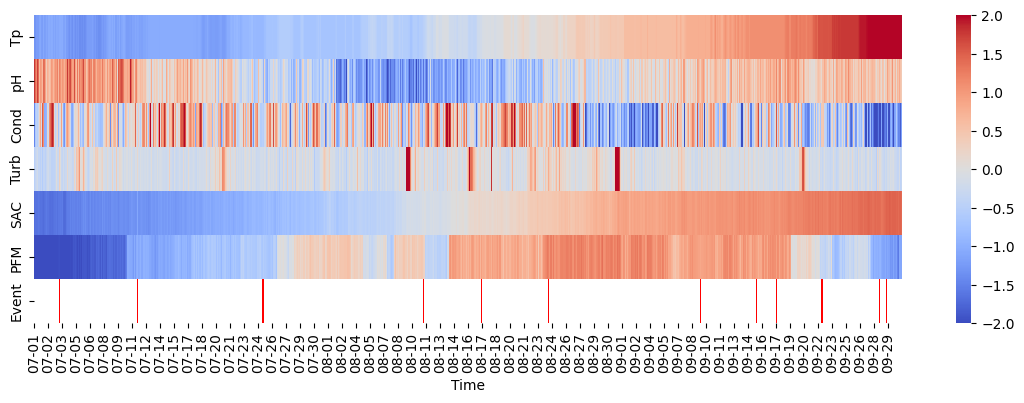

In [19]:
fig, ax = plt.subplots(figsize=figsize)

# Example data with 7 rows
data = std_data.copy()
data[data_columns] = data[data_columns].clip(-2, 2)
data["Event"] = data["Event"].astype(int)
events = data[data["Event"] > 0]
data['Event'] = data['Event'].rolling(window=151, center=True, min_periods=1).max()
data.index = data.index.strftime('%m-%d')

data = data.T

# First mask: show only rows 0-5
mask1 = np.zeros_like(data, dtype=bool)
mask1[-1, :] = True  # hide last row

# Second mask: show only the last row
mask2 = np.ones_like(data, dtype=bool)
mask2[-1, :] = False  # hide first 6 rows

sns.heatmap(data, ax=ax, cmap="coolwarm", mask=mask1)
sns.heatmap(data, ax=ax, cmap=ListedColormap(["white", "red"]), mask=mask2, cbar=False)

plt.show()

## Autocorrelation Plot
As we can see in the heatmap, a few features show a strong temporal correlation. Having a look at the autocorrelation plot confirms that for a few features, there is a significant temporal correlation. These global trends can be problematic for models that rely on the assumption of independent observations. When data points are closely linked in time, it becomes harder to distinguish local trends and patterns from global trends which makes it challenging to identify true causal relationships.

Autocorrelation across 8 days:


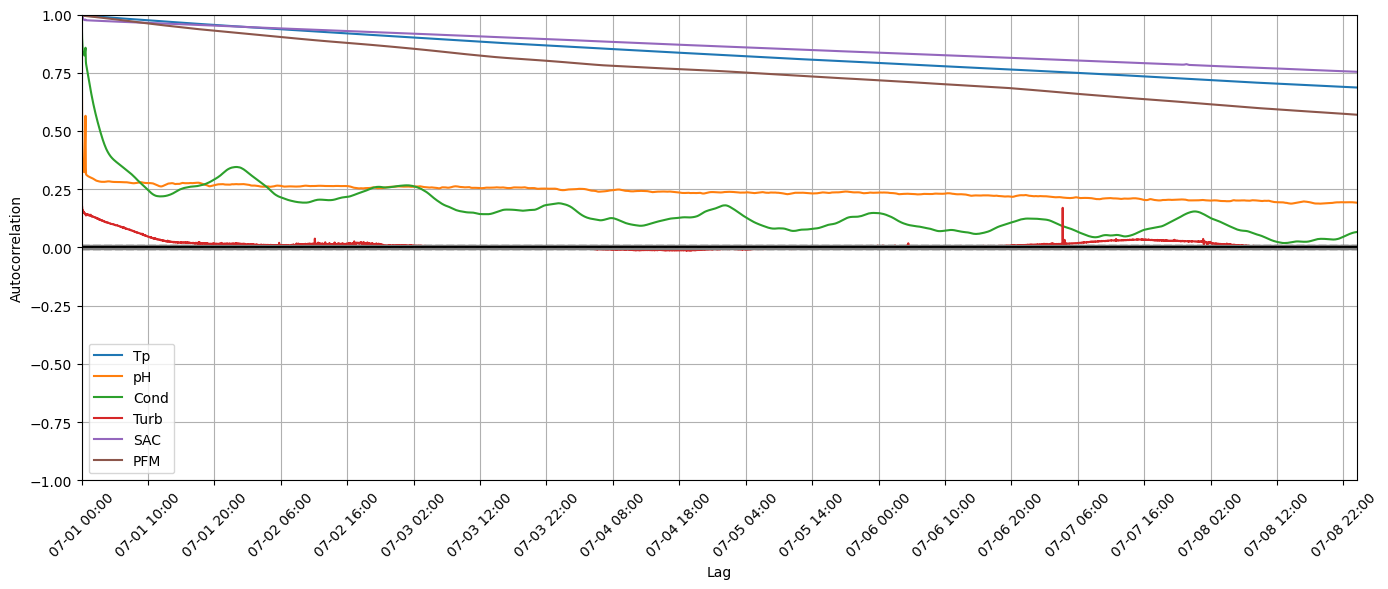

Autocorrelation across the entire timespan:


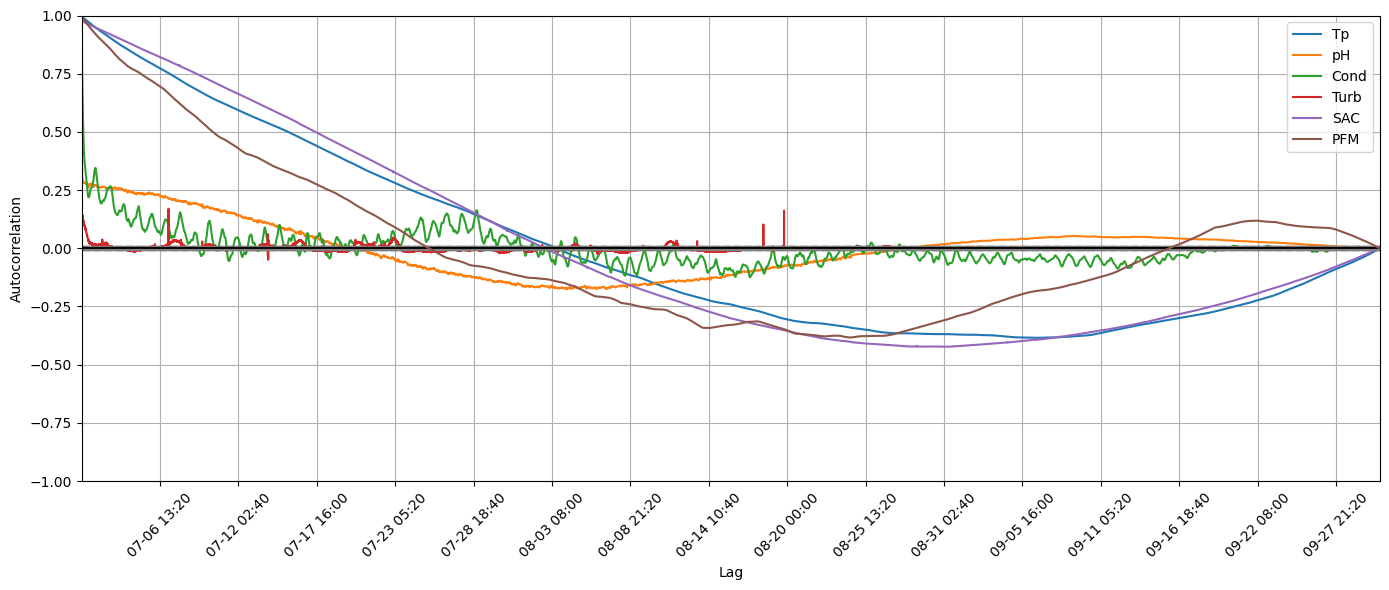

In [22]:
filled_without_event = [filled_data[c] for c in filled_data.columns]
print("Autocorrelation across 8 days:")
util.plot_multiple_autocorrelations(filled_without_event, pd.Timedelta(days=8) / sample_delta, (figsize[0], 6))
print("Autocorrelation across the entire timespan:")
util.plot_multiple_autocorrelations(filled_without_event, figsize=(figsize[0], 6))

In the first plot, we see the autocorrelation zoomed in to 8 days. Here, we see that the `Cond`–column is the only one which shows a period (daily).
However, we see that all columns instead of `Turb` are strongly temporally correlated, at least with regard to one forth of the values.
In the latter plot, we can draw similar conclusions across a larger timeframe:

- For `Tp`, `SAC` and less so `PFM`, we observe a strong temporal correlation and periodic behavior with a very long period.
    Adding interpretation, we see that these columns correlate with the annual seasons.
    This is most intuitive for the temperature of the water.
- For `pH` and `Cond`, it seems that only one 4th of values are temporally correlated at maximum. They seem to be periodic with small and varying periods.
- `Turb` seems neither periodic nor temporally correlated. There are spikes of correlation, which might indicate anomalies or noise, which have strong momentum with respect to the rest of the column.

## Correlation Matrix
Indeed, the inter–column–correlation matrix roughly confirms these correlations:

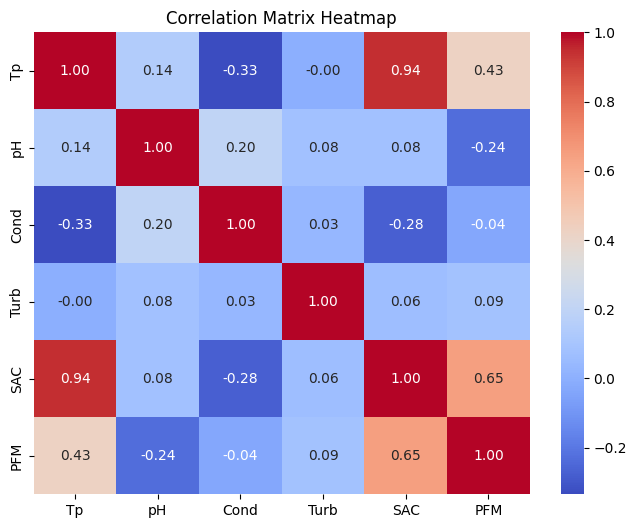

In [23]:
# Calculate the correlation matrix
correlation_matrix = filled_data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Display the heatmap
plt.title("Correlation Matrix Heatmap")
plt.show()

## Sliding Window
Unfortunately, we do not see a single period across all columns but rather different periodic patterns. 
What we could do is augment the data with additional columns for each period we identify and expect our models
to learn the association between the right data column and the right period column.

However, this increases complexity and the model would additionally have to learn the correlations between the right columns and the right periods.

On top of that, the period is very long, including tens of thousands of samples (expect for the daily period of `Cond`).
Therefore, the information gained would not be large.

We could add a column for the daily period. However, since the `Cond`–column is the only one gaining from that, we decide not to occupy ourselves with that.
As such, we skip augmentation by period–columns entirely and instead implement the sliding window approach seen in the lecture.

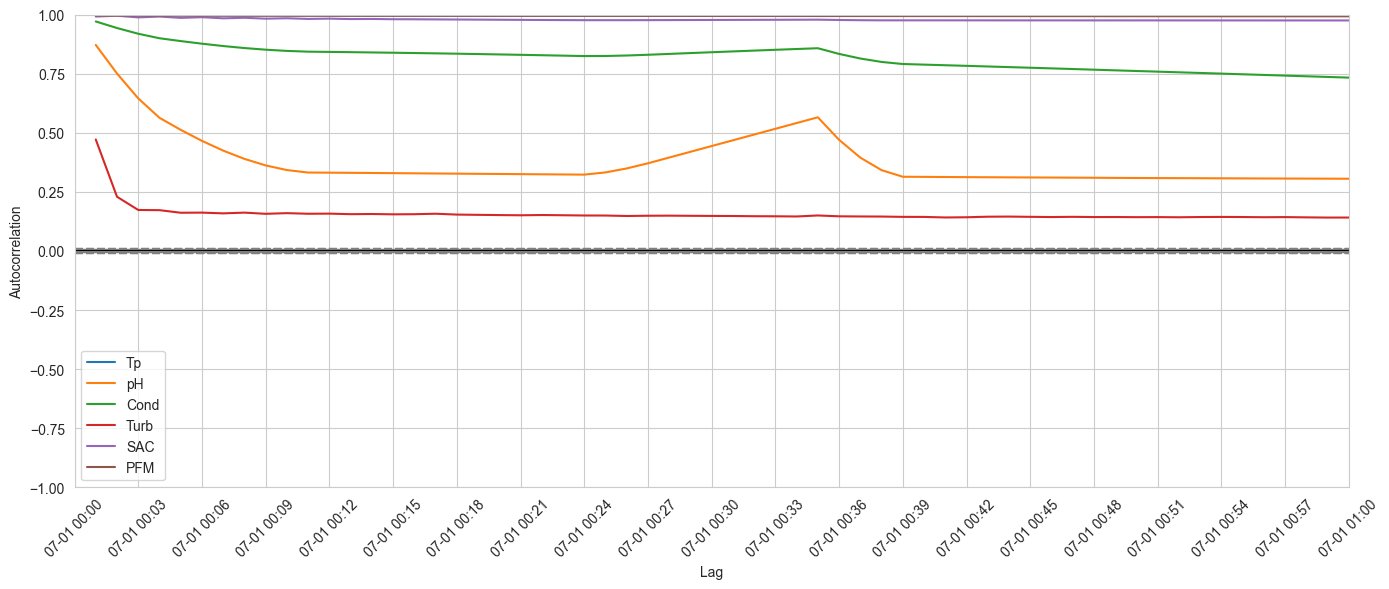

In [ ]:
util.plot_multiple_autocorrelations([filled_data[c] for c in filled_data.columns.drop("Event")], pd.Timedelta(hours=1) / sample_delta, (figsize[0], 6))

In [26]:
window_length = 10
aggregation_length = 50

Here, we zoomed into yet more detail to determine the exact length of our windows.
We will take `window_length` lags as window length.
This should be more than enough to capture `pH` and `Turb`.

The other three correlate for durations which are too long to capture them all.
For this reason, we apply the aggregation technique from the lecture.
In the lecture, we only applied this technique with non–overlapping bins.
However, there is no reason we can't apply it windows as well.
The computation is very expensive but we do not care.
We use the metrics `Variance`, `Median` and `Average` over an arbitrarily but long enough chosen aggregation window of `aggregation_length` lags.
The intuitive idea is to have those values indicate the "underlying" state of the columns
over the `aggregation_length` samples in the environment of one sample.
This shall help us because it might give an additional cue when the `window_length` values from the window might all stray away from
this actual state that the column should have.

The last element of the windows will be aligned.
The longer aggregation windows will extend further into the past than the windows.

In [27]:
filled_without_event = filled_data
windows_data = util.sliding_window(filled_without_event, window_length)
aggregates = filled_without_event.rolling(window=aggregation_length, min_periods=1).agg(['var', 'median', 'mean'])
augmented_data = pd.concat([windows_data, aggregates.iloc[window_length-1:]], axis=1)
augmented_data.columns = pd.MultiIndex.from_tuples([c if isinstance(c, tuple) else ("window", c) for c in augmented_data.columns])

# Cost Model
In order to evaluate our results, we need to develop a cost model. However, this is challenging because there are various types of anomalies — microbial contamination, small leaks, issues that could potentially lead to catastrophic failure, and chemical contamination—all of which have different remedial actions, fines, and associated costs. Furthermore, assessing the cost of missing an anomaly is extremely difficult because it includes predicting future fines or accumulated failure avoided if a pipe was serviced after the our alarm.

We will try anyway. In our cost model, we only want to consider the cost $c_{alarm}$ and $c_{miss}$, which is the cost of reacting to an alarm when there actually was no problem and the cost of missing an anomaly.

According to [Home Advisor](https://sagesure.com/insurance-insights/who-pays-to-repair-a-water-service-line-break/#:~:text=According%20to%20Home%20Advisor%20the,repairs%20may%20total%20nearly%20%244%2C000), the average cost of water line repair is appoximately 1k€.

With regards to water breaks, at the time of this writing, [watermainbreakclock.com](https://watermainbreakclock.com/#:~:text=The%20burden%20of%20old%20technology,related) cited 6,530,406 broken water mains and $65,304,060,752 in water main repair costs. This means on average, a water break costs roughly 10k€. However, since we do not know what percentage of anomalies lead to catastrophic failures, we are unable to measure the cost of one structural anomaly.

The fines for contaminations in the water account [approximately](https://www.californiawaterviews.com/epa-announces-update-to-civil-monetary-penalties-impacts-on-water-providers#:~:text=,1%2C643%2C738%20for%20successful%20tampering) 60k€/day. Downscaling to our 5–minute–timescale, this roughly comes out to 208€/5 Minutes.
As such, we can argue that missing a contamination anomaly is worth 208€ (Afterall, 5 minutes of servicing it earlier saves on average, this amount of money).

At this point, we observe that the calculations are unreliable and riddled with assumptions.
For this reason, we will not try to revise this cost model further.
Instead, we will use the F1–score.

## F1-Score
As explained above and also suggested by the publishers of the challenge, we will use the F1–score to evaluate the performance of our models. The F1–score is defined as the harmonic mean of the precision and recall and is calculated as:

$$
F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}.
$$

Recall and precision can be calculated using a so-called confusion matrix. The confusion matrix is a tool used to evaluate the performance of a classification model by displaying the counts of true and false predictions. It is structured as a 2x2 table where the rows represent the actual classes and the columns represent the predicted classes. In binary classification, the matrix includes four outcomes:
1. **True Positives** (TP), where the model correctly predicts the positive class
2. **False Positives** (FP), where the model incorrectly predicts the positive class
3. **False Negatives** (FN), where the model misses positive cases by predicting them as negative
4. **True Negatives** (TN), where the model correctly predicts the negative class.

|                       | **Predicted Positive** | **Predicted Negative** |
|-----------------------|------------------------|------------------------|
| **Actual Positive**   | True Positive (TP)     | False Negative (FN)    |
| **Actual Negative**   | False Positive (FP)    | True Negative (TN)     |

**Precision** indicates the accuracy of positive predictions, while **recall** reflects the model’s ability to capture all positive instances. They are calculated as:

$$
precision = \frac{TP}{TP + FP}
$$

$$
recall = \frac{TP}{TP + FN}
$$